In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import os
from scipy.optimize import fsolve

from laser_measles.generic import Model
from laser_measles.generic import Infection
from laser_measles.generic import Exposure
from laser_measles.generic import Susceptibility
from laser_measles.generic import Transmission
from laser_measles.generic import BirthsConstantPop
from laser_measles.generic.components.importation import InfectAgentsInPatch

from laser_measles.generic.utils import set_initial_susceptibility_in_patch
from laser_measles.generic.utils import seed_infections_in_patch


Construct the synthetic populations. We'll have 61 patches with populations distributed logarithmicaly between 1k and 1M people.

In [2]:
nticks = 10 * 365 # lenth of the simulation in days
npatches = 61 # number of patches (spatial units)
pops = np.logspace(3, 6, npatches)
scenario = pd.DataFrame({"ids": [str(i) for i in range(npatches)], "population": pops})

Run `nsims=200` iterations sampling over R0, mean infectious perios, and crude birth rate

In [ ]:
nsims = 1 # 200
R0_samples = np.random.uniform(3, 16, nsims)
infmean_samples = 5 + np.random.gamma(2, 10, nsims)
cbr_samples = 10 + np.random.gamma(2, 20, nsims)
i = 0
outputs = np.zeros((nsims, nticks, npatches))
# Create a folder to store the outputs
output_folder = os.path.abspath(os.path.join(os.getcwd(), "CCS"))
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for R0, infmean, cbr in zip(R0_samples, infmean_samples, cbr_samples):
    parameters = PropertySet(
        {
            "seed": np.random.randint(0, 1000000),
            "nticks": nticks,
            "verbose": True,
            "beta": R0 / infmean,
            "inf_mean": infmean,
            "exp_mu": 2.5,
            "exp_sigma":0.4,
            "inf_shape": 2,
            "cbr": cbr,
            "importation_period": 180,
            "importation_end": 20 * 365,
        }
    )

    mu = (1 + parameters.cbr / 1000) ** (1 / 365) - 1

    model = Model(scenario, parameters)
    model.components = [
        BirthsConstantPop,
        Susceptibility,
        Exposure,
        Infection,
        Transmission,
        InfectAgentsInPatch,
    ]

    # Start them slightly asynchronously - different initial susceptibilities, infection only in 1 patch
    # Want to see how connectivity drives correlation over time.
    for j in range(npatches):
        set_initial_susceptibility_in_patch(model, j, 1 / R0 + 0.1 / R0 * np.random.normal())

    model.run()
    outputs[i, :, :] = model.patches.cases_test
    np.save(f"{output_folder}/CCSSIRoutputs_{i}.npy", outputs[i, :, :])
    i += 1

2025-06-15 12:47:13.332943: Creating the generic model…
Initializing the generic model with 61 patches…
2025-06-15 12:47:13.737600: Running the generic model for 3650 ticks…


100%|██████████| 3650/3650 [05:57<00:00, 10.20it/s]

Completed the generic model at 2025-06-15 12:53:11.592822…
Susceptibility_census:       131,568 µs
Exposure_census      :        39,942 µs
Infection_census     :       131,438 µs
Transmission_census  :        23,696 µs
Model                :        17,318 µs
BirthsConstantPop    :   117,137,048 µs
Susceptibility       :        10,284 µs
Exposure             :   189,554,080 µs
Infection            :   188,627,770 µs
Transmission         :   195,372,210 µs
InfectAgentsInPatch  :    18,417,696 µs
Total:                   709,463,050 microseconds


In [10]:
print(model.population.susceptibility.min(), model.population.susceptibility.max())
print(model.population.susceptibility.sum())


0 1
12414


In [13]:
print(model.population.itimer.max(), model.population.itimer.min())
print(np.sum(model.population.itimer > 0))

57 0
5919


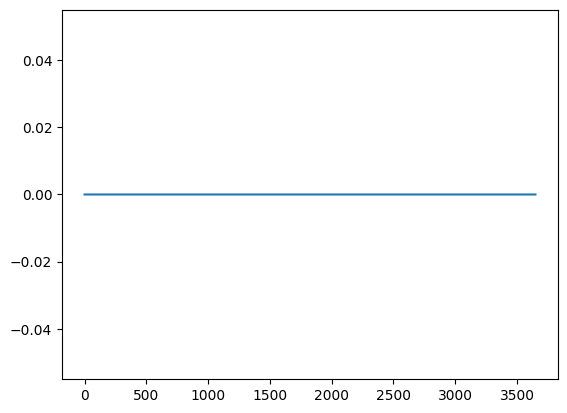

In [5]:
plt.plot(outputs.sum(axis=-1).flatten())

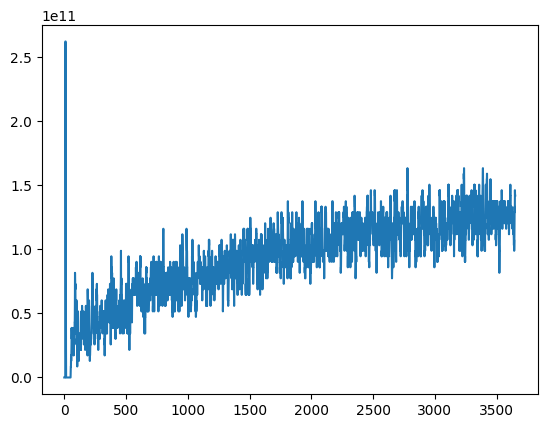

In [16]:
plt.plot(model.patches.cases_test.sum(axis=-1))

In [18]:
model.patches.cases.dtype

dtype('uint32')

In [19]:
model.patches.cases_test.dtype

dtype('uint32')

In [20]:
hasattr(model.population, "etimer")

True